<h2> Redes Neurais e Aprendizado Profundo <h2>

- Transferencia de aprendizado: carregando CNN pré treinada e realizando finetuning


## Parte 0 - Bibliotecas e Dataset

In [19]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import gdown

import numpy as np
import matplotlib.pyplot as plt
import os

Realizando o download  do dataset da `caltech256` modificado. Com apenas três classes.

In [2]:
#Link de compartilhamento
#https://drive.google.com/file/d/1qUEWHldIP7wCnhkEEDWwyJiPKU9zk68F/view?usp=sharing

!gdown --id '1qUEWHldIP7wCnhkEEDWwyJiPKU9zk68F' #Referenciando apenas o ID do link e baixo o dataset
!unzip caltec256subset.zip #Descompactando o dataset

/home/marcus/codes/vamosrodar/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qUEWHldIP7wCnhkEEDWwyJiPKU9zk68F
To: /home/marcus/codes/caltec256subset.zip
100%|██████████████████████████████████████| 15.7M/15.7M [00:00<00:00, 28.3MB/s]
Archive:  caltec256subset.zip
   creating: caltec256subset/
   creating: caltec256subset/test/
  inflating: caltec256subset/test/009_0098.jpg  
  inflating: caltec256subset/test/090_0107.jpg  
  inflating: caltec256subset/test/150_0044.jpg  
   creating: caltec256subset/train/
   creating: caltec256subset/train/bear/
  inflating: caltec256subset/train/bear/009_0001.jpg  
  inflating: caltec256subset/train/bear/009_0002.jpg  
  inflating: caltec256subset/train/bear/009_0003.jpg  
  inflating: caltec256subset/train/bear/009_0004.jpg  
  inflating: cal

Aplicando transformações nos dados.

Note que atribuímos operações de `data augmentation` nos dados com as seguintes operações:

- `RandomSizedCrop:` basicamente pega num recorte de uma imagem em várias escalas entre 0,01 e 0,8 vezes o tamanho da imagem e redimensiona para um determinado número.

- `RandomRotation:` rotaciona a imagem em um certo ângulo.

- `RandomHorizontal:` é uma técnica comum na visão computacional para aumentar o tamanho do conjunto de dados. Em primeiro lugar, aumenta o número de vezes que a rede consegue a ver a mesma coisa e, em segundo lugar, acrescenta invariância rotacional à aprendizagem das redes.

- `CenterCrop:` recorta a imagem dada no centro.



In [3]:
image_transforms = { 

    #Dividindo os conjuntos de teste em treino, validação e teste
    
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),


    'valid': transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),


    'test': transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
}

A normalização (`Normalize`) pode gerar cursiosidade para saber de onde vieram estes números? 

Na sua maioria, foram utilizados em arquiteturas populares como no paper da AlexNet. 

É importante normalizar o conjunto de dados, calculando a média e o desvio padrão das imagens do conjunto de dados e tornando a unidade de dados normalizada. No entanto, é necessário muito cálculo para o fazer, e alguns papers mostraram que não importa muito se estiverem ligeiramente desfasados. 
Por isso, as pessoas utilizam apenas o do ImageNet do conjunto de dados para normalizar aproximadamente o seu conjunto de dados. Estes números são a média e o desvio padrão do dataset ImageNet!

In [4]:
#Carregando o Dataset

#Setando o caminho (path) do nosso dataset
dataset = 'caltec256subset'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

#Tamanho do batch size (obs: vocês podem mudar o tamanho para inferências de outros comportamento da rede)
bs = 32

#Números de classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(f'Número de classes do nosso dataset {num_classes}\n')


#Carregando os dados das pastas
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

#Apresentando dos índices dos nomes das classes
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

#Dimensão dos dados, a utilizar para calcular a média do loss e a acurácia
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])


#Criando iteradores para os dados carregados com o módulo DataLoader
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

Número de classes do nosso dataset 3

{0: 'bear', 1: 'gorilla', 2: 'other'}


In [5]:
#Printando o tamanho do conjunto de treino e validção
train_data_size, valid_data_size

(150, 60)

## Parte 2 - Carregando o nosso modelo pré-treinado e aplicando fine-tuning

Apresentando diversos modelos/arquiteturas de Deep Learning por meio da biblioteca `torchvision` do pytorch

In [6]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

Neste exemplo optaremos por utilizar a `ResNet50`.

In [7]:
resnet = models.resnet.resnet50(pretrained=True)
resnet

/home/marcus/codes/vamosrodar/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marcus/codes/vamosrodar/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Podemos perceber que na linha `(fc): Linear(in_features=2048, out_features=1000, bias=True)` a saída contém 1000 saídas.

Iremos aplicar o `fine-tunining` adaptando para o problema de domínio baseado no nosso dataset. Alterando a saída da nossa rede.

In [8]:
#Congelando os parâmetros do nosso modelos carregado
for param in resnet.parameters():
    param.requires_grad = False

In [9]:
#Alterarando a camada final do modelo ResNet50 para a aprendizagem por transferência

num_ftrs = resnet.fc.in_features #Acessando a saída da arquitetura da rede por meio da camada fc
resnet.fc = nn.Linear(num_ftrs, num_classes) #Altrando para a saída junto ao nosso dataset
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
summary( resnet, (3, 224, 224) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Parte 3 - Teinando a nossa rede ResNet50

In [11]:
#Definindo a função de otimização e perda
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [12]:
#Função de treinamento de validação da rede, baseado no exemplo de Dennis Madsen: https://www.youtube.com/watch?v=8etkVC93yU4
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Clean existing gradients
            optimizer.zero_grad()

            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [13]:
#Treinando a nossa rede 
num_epochs =  10
trained_model, history = train_and_validate(resnet, loss_func, optimizer, num_epochs)

Epoch: 1/10
Epoch : 001, Training: Loss: 1.0102, Accuracy: 58.0000%, 
		Validation : Loss : 0.7198, Accuracy: 86.6667%, Time: 0.6578s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.6082, Accuracy: 92.6667%, 
		Validation : Loss : 0.5019, Accuracy: 88.3333%, Time: 0.6329s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.4131, Accuracy: 94.0000%, 
		Validation : Loss : 0.3899, Accuracy: 91.6667%, Time: 0.6277s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.3196, Accuracy: 93.3333%, 
		Validation : Loss : 0.3531, Accuracy: 86.6667%, Time: 0.6225s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.2905, Accuracy: 93.3333%, 
		Validation : Loss : 0.3105, Accuracy: 88.3333%, Time: 0.6369s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.2487, Accuracy: 92.6667%, 
		Validation : Loss : 0.2870, Accuracy: 93.3333%, Time: 0.6274s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.1785, Accuracy: 95.3333%, 
		Validation : Loss : 0.2767, Accuracy: 90.0000%, Time: 0.6326s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.1931, Accuracy: 94.

## Parte 4 - Plot das curvas de aprendizagem

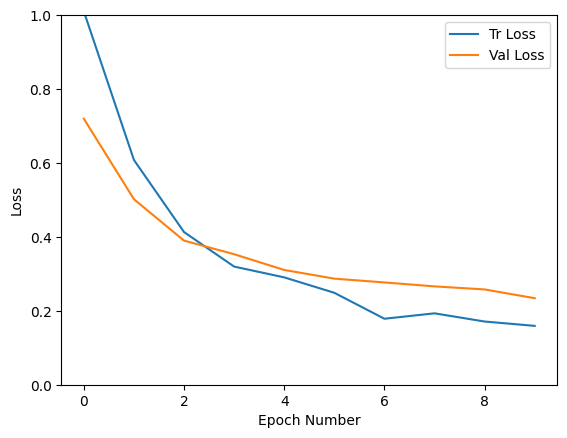

In [14]:
#Plots das curvas aprendizagem

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()

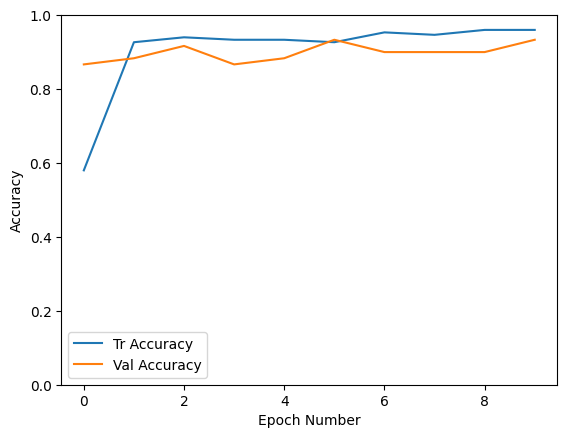

In [15]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

## Rerefências

- **Pytorch_fine_tuning_Tutorial:** https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial/blob/master/main_fine_tuning.py
- **PyTorch - The Basics of Transfer Learning with TorchVision and AlexNet:** https://www.youtube.com/watch?v=8etkVC93yU4
- **Load & FineTune Pretrained Model in PyTorch:** https://www.kaggle.com/code/dasmehdixtr/load-finetune-pretrained-model-in-pytorch
- **Fine Tuning Pretrained Model MobileNet_V2 in Pytorch:** https://saturncloud.io/blog/fine-tuning-pretrained-model-mobilenetv2-in-pytorch/
- **Transfer Learning with PyTorch: Boosting Model Performance:** https://datagy.io/pytorch-transfer-learning/
- **Pytorch Transfer Learning and Fine Tuning Tutorial:** https://www.youtube.com/watch?v=qaDe0qQZ5AQ